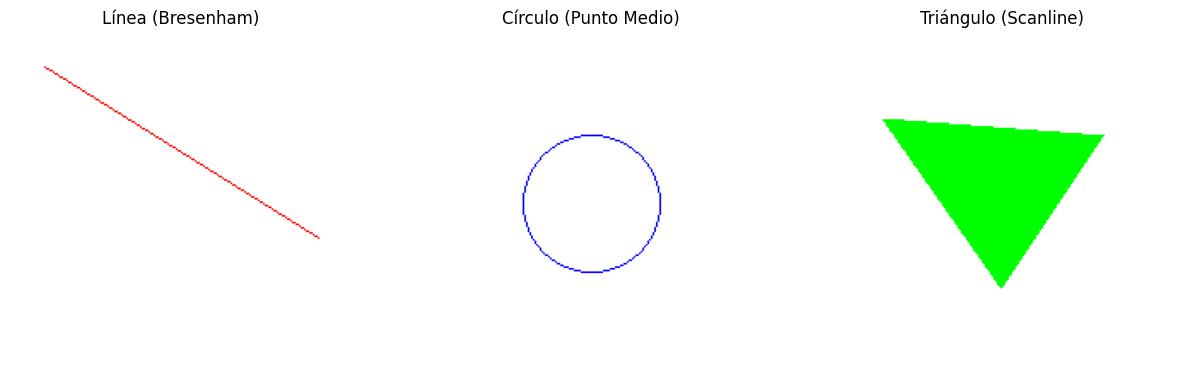

In [74]:
# Importar librerías necesarias
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 1. Preparar el entorno de dibujo
# Definimos el tamaño de la imagen (200x200 píxeles) y creamos una imagen blanca en formato RGB.
width, height = 200, 200
image = Image.new('RGB', (width, height), 'white')
pixels = image.load()  # Accedemos a los píxeles de la imagen para modificarlos directamente.

# 2. Algoritmo de Bresenham para dibujar una línea
def bresenham(x0, y0, x1, y1):
    """
    Dibuja una línea entre (x0, y0) y (x1, y1) usando el algoritmo de Bresenham.
    Este algoritmo selecciona los píxeles más cercanos a la línea ideal minimizando
    operaciones y usando solo aritmética entera para mayor eficiencia.
    """
    # Calcular diferencias absolutas en x e y para determinar la distancia a recorrer.
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    # Determinar la dirección del recorrido: 1 para incrementar, -1 para decrementar.
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1

    # Inicializar el error inicial, que decide qué píxel elegir en cada paso.
    # Se deriva de la ecuación de la línea y se ajusta para usar enteros.
    err = dx - dy

    while True:
        # Establecer el píxel actual en rojo (255, 0, 0).
        pixels[x0, y0] = (255, 0, 0)

        # Si hemos llegado al punto final, terminamos el bucle.
        if x0 == x1 and y0 == y1:
            break

        # Calcular el doble del error para tomar decisiones sobre el siguiente píxel.
        e2 = 2 * err

        # Si e2 > -dy, el error indica que debemos movernos en x (horizontalmente).
        # Restamos dy al error para compensar el avance.
        if e2 > -dy:
            err -= dy
            x0 += sx

        # Si e2 < dx, el error indica que debemos movernos en y (verticalmente).
        # Sumamos dx al error para compensar el avance.
        if e2 < dx:
            err += dx
            y0 += sy

# Probar el algoritmo de Bresenham dibujando una línea desde (20, 20) hasta (180, 120).
bresenham(20, 20, 180, 120)
image.save('resultados/linea.png')  # Guardar la imagen generada.

# 3. Algoritmo de punto medio para dibujar un círculo
def midpoint_circle(x0, y0, radius):
    """
    Dibuja un círculo centrado en (x0, y0) con un radio dado usando el algoritmo de punto medio.
    Este algoritmo aprovecha la simetría del círculo (8 octantes) para dibujar solo una parte
    y replicar los puntos, minimizando cálculos.
    """
    # Inicializamos las coordenadas iniciales: empezamos en (radius, 0).
    x = radius
    y = 0

    # Inicializamos el parámetro de decisión (p) basado en la ecuación del círculo.
    # p = 1 - radius es el valor inicial derivado de la ecuación x^2 + y^2 = r^2.
    p = 1 - radius

    # Continuamos mientras x >= y (dibujamos solo el primer octante).
    while x >= y:
        # Dibujamos los 8 puntos simétricos del círculo en los octantes.
        # Cada tupla (dx, dy) representa un desplazamiento desde el centro (x0, y0).
        for dx, dy in [(x, y), (y, x), (-x, y), (-y, x), (-x, -y), (-y, -x), (x, -y), (y, -x)]:
            # Verificamos que el píxel esté dentro de los límites de la imagen.
            if 0 <= x0 + dx < width and 0 <= y0 + dy < height:
                pixels[x0 + dx, y0 + dy] = (0, 0, 255)  # Color azul para el círculo.

        # Incrementamos y para avanzar al siguiente píxel en el octante.
        y += 1

        # Actualizamos el parámetro de decisión p.
        if p <= 0:
            # Si p <= 0, el siguiente punto está más cerca en x, no cambiamos x.
            p = p + 2*y + 1
        else:
            # Si p > 0, el siguiente punto requiere disminuir x.
            x -= 1
            p = p + 2*y - 2*x + 1

# Crear una nueva imagen para el círculo (evitar superposición con la línea).
image = Image.new('RGB', (width, height), 'white')
pixels = image.load()
# Probar el algoritmo dibujando un círculo centrado en (100, 100) con radio 40.
midpoint_circle(100, 100, 40)
image.save('resultados/circulo.png')  # Guardar la imagen generada.

# 4. Rellenar un triángulo con el algoritmo de scanline
def fill_triangle(p1, p2, p3):
    """
    Rellena un triángulo definido por los puntos p1, p2, p3 usando el algoritmo de scanline.
    Ordena los vértices por y, interpola los bordes y rellena los píxeles entre ellos.
    """
    # Ordenar los puntos por su coordenada y (de menor a mayor) para facilitar el recorrido.
    pts = sorted([p1, p2, p3], key=lambda p: p[1])
    (x1, y1), (x2, y2), (x3, y3) = pts  # Desempaquetar los puntos ordenados.

    def interpolate(y0, y1, x0, x1):
        """
        Interpola las coordenadas x entre y0 e y1 para los valores x0 y x1.
        Devuelve una lista de coordenadas x para cada y en el rango [y0, y1).
        """
        if y1 - y0 == 0:
            return []  # Evitar división por cero si los puntos están en la misma línea y.
        # Calcular x para cada y usando la ecuación de la recta: x = x0 + (x1 - x0) * (y - y0) / (y1 - y0).
        return [int(x0 + (x1 - x0) * (y - y0) / (y1 - y0)) for y in range(y0, y1)]

    # Interpolar los bordes del triángulo:
    # - x12: borde entre el punto 1 (x1, y1) y el punto 2 (x2, y2).
    # - x23: borde entre el punto 2 (x2, y2) y el punto 3 (x3, y3).
    # - x13: borde entre el punto 1 (x1, y1) y el punto 3 (x3, y3).
    x12 = interpolate(y1, y2, x1, x2)
    x23 = interpolate(y2, y3, x2, x3)
    x13 = interpolate(y1, y3, x1, x3)

    # Combinar x12 y x23 para obtener el borde "izquierdo" o "derecho" del triángulo.
    x_left = x12 + x23

    # Recorrer las líneas horizontales (scanlines) desde y1 hasta y3.
    # Para cada y, dibujamos píxeles entre las coordenadas x de los bordes.
    for y, xl, xr in zip(range(y1, y3), x13, x_left):
        # Dibujar píxeles desde el mínimo hasta el máximo de xl y xr.
        for x in range(min(xl, xr), max(xl, xr)):
            # Verificar que el píxel esté dentro de los límites de la imagen.
            if 0 <= x < width and 0 <= y < height:
                pixels[x, y] = (0, 255, 0)  # Color verde para el triángulo.

# Crear una nueva imagen para el triángulo (evitar superposición).
image = Image.new('RGB', (width, height), 'white')
pixels = image.load()
# Probar el algoritmo rellenando un triángulo con vértices en (30, 50), (100, 150), (160, 60).
fill_triangle((30, 50), (100, 150), (160, 60))
image.save('resultados/triangulo.png')  # Guardar la imagen generada.

# 5. Mostrar los resultados
# Crear una figura con tres subgráficos para mostrar las imágenes generadas.
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Image.open('resultados/linea.png'))
plt.title('Línea (Bresenham)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open('resultados/circulo.png'))
plt.title('Círculo (Punto Medio)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open('resultados/triangulo.png'))
plt.title('Triángulo (Scanline)')
plt.axis('off')

plt.show()